In [1]:
# Import necessary libraries
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional
from keras.regularizers import l1_l2
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

import datetime
import pytz

2024-02-23 22:47:30.647761: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Fetch stock data and earnings dates with improved error handling
def fetch_stock_data_with_earnings(ticker, period):
    try:
        stock = yf.Ticker(ticker)

        data = stock.history(period=period)
        data.index = data.index.date

        earnings = stock.earnings_dates
        earnings.index = earnings.index.date
        
        return data, earnings
    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}")
        return None, None

In [3]:
# Fetch stock data
ticker = "TSLA"
period = "2y"

data, earnings = fetch_stock_data_with_earnings(ticker, period)
if data is None:
    raise ValueError("Failed to fetch stock data.")

In [4]:
# Fetch S&P 500 historical data
sp500 = yf.Ticker("^GSPC")
sp500_data = sp500.history(period=period)
sp500_data.index = sp500_data.index.date

data_sp500 = sp500_data[['Close']] 
data_sp500.columns = ['SP500_Close']    # Rename the columns for clarity and to avoid conflicts upon merging

# Merge the S&P 500 data with your existing DataFrame based on the date index
data = data.merge(data_sp500, how='left', left_index=True, right_index=True)

# Drop 'Dividends' and 'Stock Splits' and compute additional technical indicators
data = data.drop(columns=['Dividends', 'Stock Splits'])

data.tail()

,Open,High,Low,Close,Volume,SP500_Close
2024-02-16,202.059998,203.169998,197.399994,199.949997,111173600,5005.569824
2024-02-20,196.130005,198.600006,189.130005,193.759995,104545800,4975.509766
2024-02-21,193.360001,199.440002,191.949997,194.770004,103844000,4981.799805
2024-02-22,194.000000,198.320007,191.360001,197.410004,92739500,5087.029785
2024-02-23,195.309998,197.570007,191.500000,191.970001,78670300,5088.799805


In [5]:
# Function to check if the current time is within trading hours
def is_trading_hours():
    # Define US Eastern timezone
    eastern = pytz.timezone('US/Eastern')
    
    # Get current time in Eastern timezone
    now_eastern = datetime.datetime.now(eastern)
    
    # Define market open and close times (9:30 AM to 4:00 PM)
    market_open = now_eastern.replace(hour=9, minute=30, second=0, microsecond=0)
    market_close = now_eastern.replace(hour=16, minute=0, second=0, microsecond=0)
    
    # Check if current time is within trading hours
    return market_open <= now_eastern <= market_close


# Check if it's trading hours before dropping the first row
if is_trading_hours():
    print('Trading Hour.')
    data = data.drop(data.tail(1).index)    # Drop the last row from the DataFrame
else:
    print('After Hour.')

After Hour.


# Indicators

### EMA (Exponential Moving Average)
- EMA is a type of moving average that places a greater weight and significance on the most recent data points. It is more responsive to new information compared to the SMA.
- Usage in analysis: EMA is often used to identify the direction of the trend, with prices above the EMA suggesting an uptrend and prices below indicating a downtrend. Traders might use short-term EMAs to make quick, momentum-based decisions and longer-term EMAs for overall trend direction.


### RSI (Relative Strength Index)
- RSI is a momentum oscillator that measures the speed and change of price movements on a scale of 0 to 100. It is used to identify overbought or oversold conditions in a security's price.
- Usage in analysis: Values above 70 are considered overbought (suggesting a potential sell signal), while values below 30 are considered oversold (indicating a potential buy signal). RSI can also show divergence signals, where the price trend and RSI trend move in opposite directions, suggesting a potential reversal.


### MACD (Moving Average Convergence Divergence)
- MACD is a trend-following momentum indicator that shows the relationship between two moving averages of a security's price. It consists of the MACD line (difference between two EMAs), a signal line (EMA of the MACD line), and a histogram (difference between MACD and its signal line).
- Usage in analysis: MACD is used to identify changes in the strength, direction, momentum, and duration of a trend. A bullish crossover occurs when the MACD crosses above its signal line, suggesting a buy signal, while a bearish crossover (MACD falls below the signal line) suggests a sell signal. The divergence between the MACD and price action can also indicate potential market reversals.

In [6]:
short_span, long_span = 10, 50

data['EMA_Short'] = data['Close'].ewm(span=short_span, adjust=False).mean()
data['EMA_Long'] = data['Close'].ewm(span=long_span, adjust=False).mean()

# data['SMA_Short'] = data['Close'].rolling(window=short_span).mean()
# data['SMA_Long'] = data['Close'].rolling(window=long_span).mean()

# RSI
delta = data['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
data['RSI'] = 100 - (100 / (1 + rs))

# MACD
exp1 = data['Close'].ewm(span=12, adjust=False).mean()
exp2 = data['Close'].ewm(span=26, adjust=False).mean()
data['MACD'] = exp1 - exp2

In [7]:
data.head()

,Open,High,Low,Close,Volume,SP500_Close,EMA_Short,EMA_Long,RSI,MACD
2022-02-24,233.463333,267.493347,233.333328,266.923340,135322200,4288.700195,266.923340,266.923340,NaN,0.000000
2022-02-25,269.743347,273.166656,260.799988,269.956665,76067700,4384.649902,267.474854,267.042294,NaN,0.241975
2022-02-28,271.670013,292.286682,271.570007,290.143341,99006900,4373.939941,271.596397,267.948217,NaN,2.039132
2022-03-01,289.893341,296.626678,284.593323,288.123322,74766900,4306.259766,274.601292,268.739398,NaN,3.262781
2022-03-02,290.709991,295.493347,281.423340,293.296661,74643300,4386.540039,278.000450,269.702428,NaN,4.596987


In [8]:
data.tail()

,Open,High,Low,Close,Volume,SP500_Close,EMA_Short,EMA_Long,RSI,MACD
2024-02-16,202.059998,203.169998,197.399994,199.949997,111173600,5005.569824,192.799912,211.610871,58.458365,-7.271002
2024-02-20,196.130005,198.600006,189.130005,193.759995,104545800,4975.509766,192.974473,210.910836,51.843668,-6.676731
2024-02-21,193.360001,199.440002,191.949997,194.770004,103844000,4981.799805,193.300933,210.277863,56.731468,-6.054476
2024-02-22,194.000000,198.320007,191.360001,197.410004,92739500,5087.029785,194.048037,209.773241,57.549002,-5.287359
2024-02-23,195.309998,197.570007,191.500000,191.970001,78670300,5088.799805,193.670212,209.075075,53.321332,-5.060047


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 502 entries, 2022-02-24 to 2024-02-23
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Open         502 non-null    float64
 1   High         502 non-null    float64
 2   Low          502 non-null    float64
 3   Close        502 non-null    float64
 4   Volume       502 non-null    int64  
 5   SP500_Close  502 non-null    float64
 6   EMA_Short    502 non-null    float64
 7   EMA_Long     502 non-null    float64
 8   RSI          489 non-null    float64
 9   MACD         502 non-null    float64
dtypes: float64(9), int64(1)
memory usage: 59.3+ KB


In [10]:
# Normalize features
features = data.columns.tolist()

# Backward Fill
data[features] = data[features].bfill()

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Create a DataFrame for the scaled data, ensuring to convert features_to_scale back to a list to maintain order
scaled_data_df = pd.DataFrame(scaled_data, columns=features, index=data.index)

# Display the scaled dataframe
scaled_data_df

,Open,High,Low,Close,Volume,SP500_Close,EMA_Short,EMA_Long,RSI,MACD
2022-02-24,0.473093,0.571451,0.504649,0.580247,0.353035,0.470753,0.629748,0.696217,0.477219,0.494938
2022-02-25,0.604654,0.592268,0.610037,0.591329,0.129202,0.534221,0.632105,0.696944,0.477219,0.499728
2022-02-28,0.611640,0.662423,0.651362,0.665079,0.215854,0.527137,0.649724,0.702487,0.477219,0.535310
2022-03-01,0.677723,0.678347,0.701331,0.657699,0.124288,0.482368,0.662570,0.707327,0.477219,0.559536
2022-03-02,0.680684,0.674189,0.689168,0.676600,0.123821,0.535472,0.677101,0.713219,0.477219,0.585952
...,...,...,...,...,...,...,...,...,...,...
2024-02-16,0.359217,0.335437,0.366775,0.335566,0.261814,0.944945,0.312882,0.357811,0.568797,0.350982
2024-02-20,0.337713,0.318669,0.335043,0.312951,0.236777,0.925061,0.313629,0.353528,0.495796,0.362748
2024-02-21,0.327668,0.321751,0.345863,0.316641,0.234126,0.929222,0.315024,0.349656,0.549739,0.375067
2024-02-22,0.329989,0.317641,0.343599,0.326286,0.192179,0.998829,0.318218,0.346569,0.558761,0.390255


In [11]:
# merge earnings data
scaled_data_df = scaled_data_df.merge(earnings, how='left', left_index=True, right_index=True)

# Forward Fill for the head rows
scaled_data_df = scaled_data_df.fillna(method='ffill')

# Backward Fill for the tail rows
scaled_data_df = scaled_data_df.fillna(method='bfill')

# Display the merged dataframe
scaled_data_df

/var/folders/hd/pv9sg75d6b38kvxtq9c67bw40000gn/T/ipykernel_11626/4154407146.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  scaled_data_df = scaled_data_df.fillna(method='ffill')
/var/folders/hd/pv9sg75d6b38kvxtq9c67bw40000gn/T/ipykernel_11626/4154407146.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  scaled_data_df = scaled_data_df.fillna(method='bfill')


,Open,High,Low,Close,Volume,SP500_Close,EMA_Short,EMA_Long,RSI,MACD,EPS Estimate,Reported EPS,Surprise(%)
2022-02-24,0.473093,0.571451,0.504649,0.580247,0.353035,0.470753,0.629748,0.696217,0.477219,0.494938,0.75,1.07,0.4256
2022-02-25,0.604654,0.592268,0.610037,0.591329,0.129202,0.534221,0.632105,0.696944,0.477219,0.499728,0.75,1.07,0.4256
2022-02-28,0.611640,0.662423,0.651362,0.665079,0.215854,0.527137,0.649724,0.702487,0.477219,0.535310,0.75,1.07,0.4256
2022-03-01,0.677723,0.678347,0.701331,0.657699,0.124288,0.482368,0.662570,0.707327,0.477219,0.559536,0.75,1.07,0.4256
2022-03-02,0.680684,0.674189,0.689168,0.676600,0.123821,0.535472,0.677101,0.713219,0.477219,0.585952,0.75,1.07,0.4256
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-16,0.359217,0.335437,0.366775,0.335566,0.261814,0.944945,0.312882,0.357811,0.568797,0.350982,0.74,0.71,-0.0439
2024-02-20,0.337713,0.318669,0.335043,0.312951,0.236777,0.925061,0.313629,0.353528,0.495796,0.362748,0.74,0.71,-0.0439
2024-02-21,0.327668,0.321751,0.345863,0.316641,0.234126,0.929222,0.315024,0.349656,0.549739,0.375067,0.74,0.71,-0.0439
2024-02-22,0.329989,0.317641,0.343599,0.326286,0.192179,0.998829,0.318218,0.346569,0.558761,0.390255,0.74,0.71,-0.0439


In [12]:
scaled_data_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 502 entries, 2022-02-24 to 2024-02-23
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          502 non-null    float64
 1   High          502 non-null    float64
 2   Low           502 non-null    float64
 3   Close         502 non-null    float64
 4   Volume        502 non-null    float64
 5   SP500_Close   502 non-null    float64
 6   EMA_Short     502 non-null    float64
 7   EMA_Long      502 non-null    float64
 8   RSI           502 non-null    float64
 9   MACD          502 non-null    float64
 10  EPS Estimate  502 non-null    float64
 11  Reported EPS  502 non-null    float64
 12  Surprise(%)   502 non-null    float64
dtypes: float64(13)
memory usage: 71.1+ KB


In [13]:
# Make 'Close' the last column
columns = [col for col in scaled_data_df.columns if col != 'Close']  # Get all columns except 'Close'
columns.append('Close')  # Add 'Close' to the end of the list

scaled_data_df = scaled_data_df[columns]

scaled_data_df

,Open,High,Low,Volume,SP500_Close,EMA_Short,EMA_Long,RSI,MACD,EPS Estimate,Reported EPS,Surprise(%),Close
2022-02-24,0.473093,0.571451,0.504649,0.353035,0.470753,0.629748,0.696217,0.477219,0.494938,0.75,1.07,0.4256,0.580247
2022-02-25,0.604654,0.592268,0.610037,0.129202,0.534221,0.632105,0.696944,0.477219,0.499728,0.75,1.07,0.4256,0.591329
2022-02-28,0.611640,0.662423,0.651362,0.215854,0.527137,0.649724,0.702487,0.477219,0.535310,0.75,1.07,0.4256,0.665079
2022-03-01,0.677723,0.678347,0.701331,0.124288,0.482368,0.662570,0.707327,0.477219,0.559536,0.75,1.07,0.4256,0.657699
2022-03-02,0.680684,0.674189,0.689168,0.123821,0.535472,0.677101,0.713219,0.477219,0.585952,0.75,1.07,0.4256,0.676600
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-16,0.359217,0.335437,0.366775,0.261814,0.944945,0.312882,0.357811,0.568797,0.350982,0.74,0.71,-0.0439,0.335566
2024-02-20,0.337713,0.318669,0.335043,0.236777,0.925061,0.313629,0.353528,0.495796,0.362748,0.74,0.71,-0.0439,0.312951
2024-02-21,0.327668,0.321751,0.345863,0.234126,0.929222,0.315024,0.349656,0.549739,0.375067,0.74,0.71,-0.0439,0.316641
2024-02-22,0.329989,0.317641,0.343599,0.192179,0.998829,0.318218,0.346569,0.558761,0.390255,0.74,0.71,-0.0439,0.326286


In [14]:
# LSTM model with l1_l2 Regularization and Dropout
def build_model(input_shape, num_layers=2, size_layer=128, dropout_rate=0.2, reg_rate=0.01, learning_rate=0.001):
    model = Sequential()
    reg = l1_l2(l1=reg_rate, l2=reg_rate)

    for i in range(num_layers):
        return_sequences = i < num_layers - 1
        model.add(Bidirectional(LSTM(size_layer, return_sequences=return_sequences, kernel_regularizer=reg), input_shape=input_shape))
        
        if return_sequences:
            model.add(Dropout(dropout_rate))
    
    model.add(Dense(1))
    
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error') # adagrad
    
    return model

# Setup early stopping to avoid overfitting
early_stopping = EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True)

In [32]:
num_layers = 1
size_layer = 100
epochs = 30
dropout_rate = 0.2
reg_rate = 0.00001
learning_rate = 0.0001
batch_size = 30

sequence_length = 20
test_size = 60

In [33]:
def create_sequences(data, sequence_length=20):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        sequence = data[i:i + sequence_length]
        target = data[i + sequence_length][-1]  # Assuming 'Close' is the last column
        X.append(sequence)
        y.append(target)
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data_df.values, sequence_length)

print(len(X), len(y))

482 482


In [34]:
X_train, X_val = X[:-test_size], X[-test_size:]
y_train, y_val = y[:-test_size], y[-test_size:]

model = build_model(input_shape=(X_train.shape[1], X_val.shape[2]),
                        num_layers=num_layers,
                        size_layer=size_layer,
                        dropout_rate=dropout_rate,
                        reg_rate=reg_rate,
                        learning_rate=learning_rate)

history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(
        X_val, y_val), callbacks=[early_stopping], verbose=1)

Epoch 1/30
15/15 [==============================] - 5s 110ms/step - loss: 0.1906 - val_loss: 0.0359
Epoch 2/30
15/15 [==============================] - 0s 21ms/step - loss: 0.0278 - val_loss: 0.0195
Epoch 3/30
15/15 [==============================] - 0s 15ms/step - loss: 0.0262 - val_loss: 0.0139
Epoch 4/30
15/15 [==============================] - 0s 14ms/step - loss: 0.0194 - val_loss: 0.0136
Epoch 5/30
15/15 [==============================] - 0s 13ms/step - loss: 0.0181 - val_loss: 0.0124
Epoch 6/30
15/15 [==============================] - 0s 13ms/step - loss: 0.0166 - val_loss: 0.0119
Epoch 7/30
15/15 [==============================] - 0s 13ms/step - loss: 0.0156 - val_loss: 0.0113
Epoch 8/30
15/15 [==============================] - 0s 13ms/step - loss: 0.0147 - val_loss: 0.0110
Epoch 9/30
15/15 [==============================] - 0s 13ms/step - loss: 0.0139 - val_loss: 0.0104
Epoch 10/30
15/15 [==============================] - 0s 13ms/step - loss: 0.0132 - val_loss: 0.0105
Epoch 11

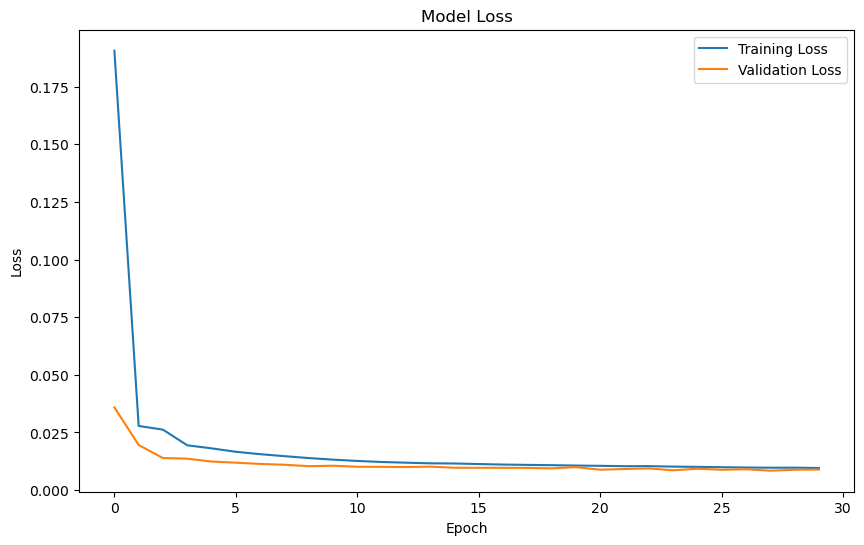

In [35]:
# Plot Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [36]:
# Make predictions on the final validation set

predictions = model.predict(X_val)

2/2 [==============================] - 1s 6ms/step


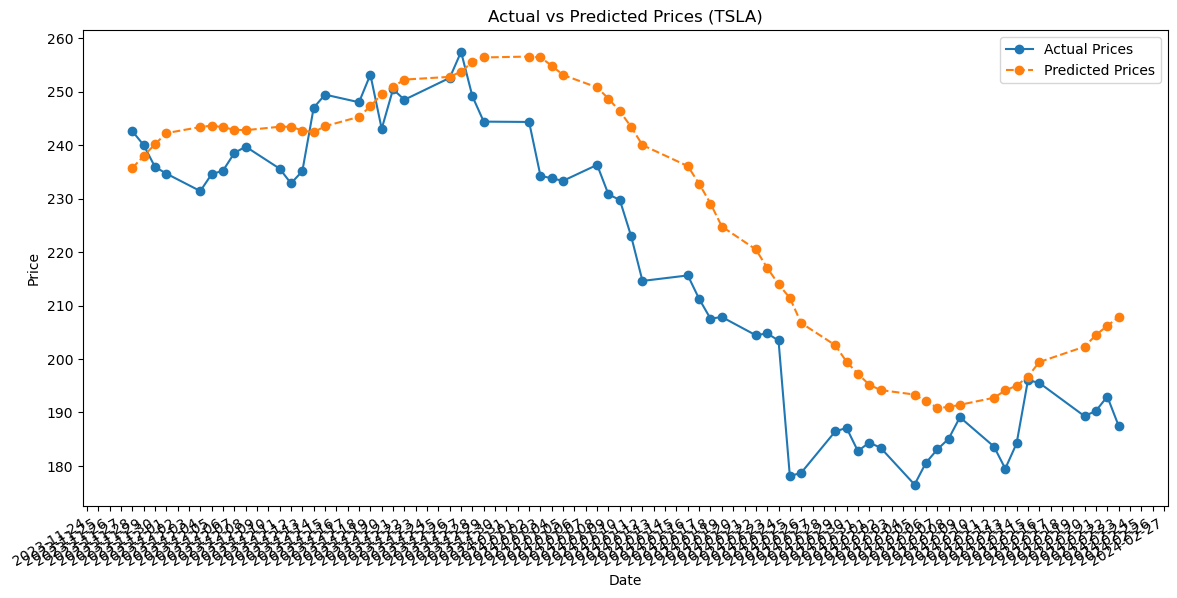

In [37]:
import matplotlib.dates as mdates 

# Plot predictions
def plot_predictions(predictions, actual, dates, title=f'Actual vs Predicted Prices ({ticker})'):
    
    plt.figure(figsize=(14, 7))
    plt.plot(dates, actual, label='Actual Prices', marker='o')
    plt.plot(dates, predictions, label='Predicted Prices', linestyle='--', marker='o')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    
    # Format the x-axis to display dates clearly
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
    plt.gcf().autofmt_xdate()  # Rotation
    
    plt.show()


predictions = scaler.inverse_transform(
        np.pad(predictions, [(0, 0), (0, len(features) - 1)], 'constant'))[:, 0]

actual = scaler.inverse_transform(
        np.pad(y_val.reshape(-1, 1), [(0, 0), (0, len(features) - 1)], 'constant'))[:, 0]

test_dates = data.index[-test_size:]

plot_predictions(predictions, actual, test_dates)

In [38]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

# Calculate evaluation metrics
mse = mean_squared_error(actual, predictions)
mae = mean_absolute_error(actual, predictions)
rmse = np.sqrt(mse)

r2 = r2_score(actual, predictions)

# Adjusted R-squared
n = sequence_length  # Number of observations
p = len(scaled_data_df.columns) - 1   # Number of predictors
adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

mape = mean_absolute_percentage_error(actual, predictions)

print("Mean Squared Error (MSE):", round(mse, 2))
print("Mean Absolute Error (MAE):", round(mae, 2))
print("Root Mean Squared Error (RMSE):", round(rmse, 2))
print("R-squared (R2):", round(r2, 2))
print("Adjusted R-squared:", round(adj_r2, 2))
print("Mean Absolute Percentage Error (MAPE):", round(mape, 2))

Mean Squared Error (MSE): 186.61
Mean Absolute Error (MAE): 11.59
Root Mean Squared Error (RMSE): 13.66
R-squared (R2): 0.73
Adjusted R-squared: 0.26
Mean Absolute Percentage Error (MAPE): 0.06


### Mean Squared Error (MSE) and Mean Absolute Error (MAE):
- These metrics measure the average error between the predicted and actual values.
- Lower values indicate better performance.
- However, the absolute scale of these metrics is dependent on the scale of your target variable. Therefore, it's difficult to define a universally "good" threshold. It's more informative to compare these metrics across different models or variations of your LSTM model.

### Root Mean Squared Error (RMSE):
- RMSE is in the same units as the target variable, which can make it more interpretable.
- Similar to MSE and MAE, lower values are desirable.
- Like MSE and MAE, it's more useful for comparing models rather than establishing absolute thresholds.

### R-squared (R2):
- R2 measures the proportion of the variance in the dependent variable that is predictable from the independent variables.
- R2 ranges from 0 to 1, with higher values indicating better fit.
- A value of 1 indicates that the model explains all the variability of the response data around its mean. However, a high R2 value doesn't necessarily mean a good model, as it may overfit.
- Generally, R2 values closer to 1 are desirable, but the interpretation depends on the context and the complexity of the model.

### Mean Absolute Percentage Error (MAPE):
- MAPE measures the average absolute percentage difference between predicted and actual values.
- Lower values indicate better performance.
- A MAPE of 0% indicates a perfect fit, but in practice, it's rare to achieve such a value.
- It's common to interpret MAPE in the context of the variability of the target variable. For example, a MAPE below 10% might be considered good in some domains.

## Predicting Future Prices

Predicting future stock prices, especially for days ahead when no known future features (like Open, High, Low, Volume, etc.) are available, is inherently challenging and uncertain due to the nature of financial markets being influenced by countless unpredictable factors.

However, this model can make predictions for the next day (or further into the future) by using the most recent data available and generating predictions iteratively. 

## Here's a simplified explanation:

Use the Most Recent Data: To predict tomorrow's closing price, you would use the most recent 'window' of data available as input. This window would include the latest values for features like Open, High, Low, Volume, technical indicators, and perhaps even the most recent closing price.

Iterative Predictions: For predictions further into the future, you would use the model's previous predictions as part of the input data for subsequent predictions. This approach, however, tends to increase uncertainty with each step into the future.

Feature Availability: For features not directly related to market prices (like EPS estimates, reported EPS, etc.), you could use the most recent available values or even forecast these features separately if they're deemed crucial for the model.

Model's Basis for Prediction: The model makes its prediction based on the learned patterns and relationships between features and the target variable (closing price) during the training phase. It essentially 'infers' the likely next value of the closing price based on how similar current conditions are to past conditions it has seen during training.

Limitations: It's important to note that such predictions are best-guess estimates and can be significantly off due to unforeseen market events or information not captured by the model. The farther into the future the prediction, the more speculative it becomes.